In [46]:
from classiq import *

### Implementing quantum walk for a circle with 4 nodes

First, we start by defining the system size:

In [47]:
size = 4

Then, we need to define functions to implement phase kickback. Assume that we have a unitary $U_j$ such that

$$ U_j |0\rangle = |\partial_j\rangle$$

Then, in order to implement the operator $2|\partial_j\rangle\langle\partial_j| - I$, we have

$$2|\partial_j\rangle\langle\partial_j| - I = U_j(2|0\rangle\langle0| - I)U_j^†$$

So, we need to implement the phase kickback in order to calculate $2|0\rangle\langle0| - I$. We have:

In [48]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

We need to implement $U_j$ such that it returns an equal superposition of states $j+1$ and $j-1$. So we implement it in the `W_iteration' function.

In the end, we need to define the full operator:

$$W = ∑_{j \in V} |j⟩⟨j| ⊗ (2|\partial_j\rangle\langle\partial_j| - I)$$

So, we implement the function `W_operator` to encode it:



In [49]:
def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0] * (2 ** size)
    if (i == 0):
      prob[i+1] = 1.0
    elif (i == 2 ** size - 1):
      prob[i-1] = 1.0
    else:
      prob[i+1] = 0.5
      prob[i-1] = 0.5
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i,vertices,adjacent_vertices)

Now, let's implement the $S$ operator:

$$S = \sum_{(j,k) \in E} |j,k \rangle\langle k,j|$$

for the implementation of `edge_oracle`, we should return 1 if and only if the difference between vertices are either +1 or -1. So, we can implement it like this:

In [50]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))
  #res |= ((vertices-adjacent_vertices) == 1 or (vertices-adjacent_vertices) == -1)


@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

Now, To run the whole algorithm, we have:

In [51]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0

This is the circuit we get in the end:

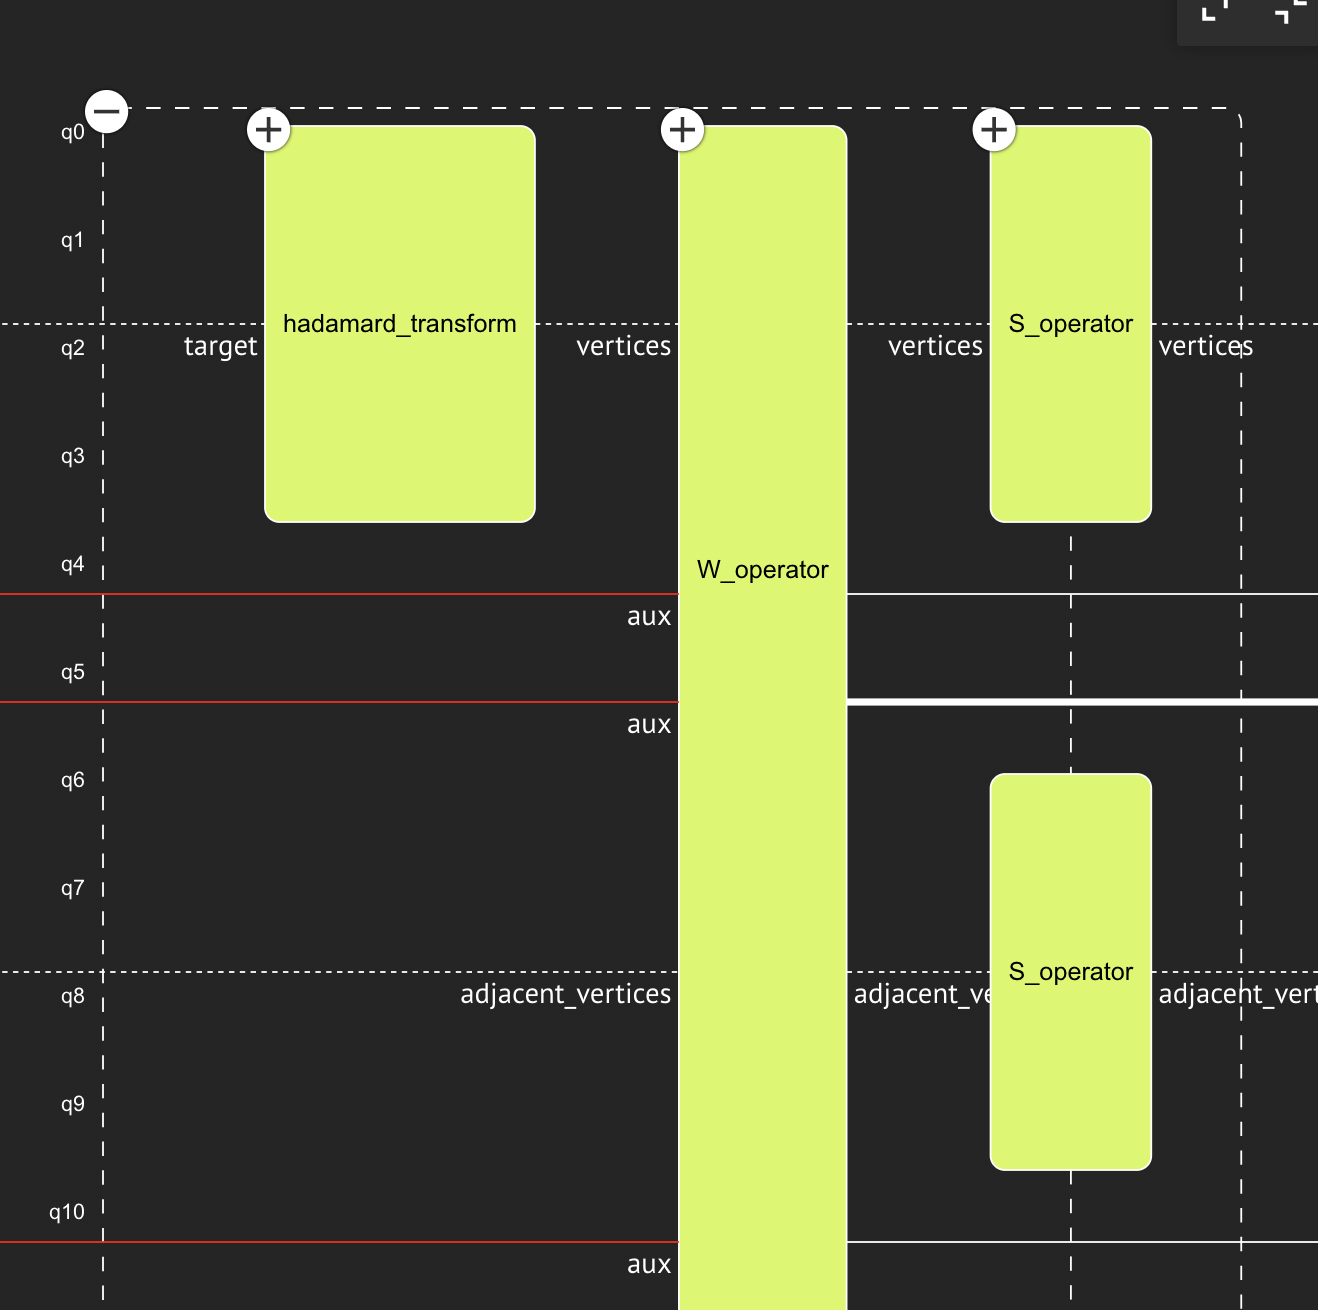